In [48]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
import torch.nn.functional as F
from nn4n.nn import (
    RNN, 
    LeakyLinearLayer, 
    RecurrentLayer,
    LinearLayer
)
from utils import visualize_response_map, RatemapAggregator
from weak_sm_cell import WeakSMCell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the trajectory and arena map

In [99]:
ARENA_NAME = '100x100_square'
explore_speed = 'fast'  # 'fast', 'med', 'slow'
boundary_avoidance = False  # True, False

load_dir = os.path.join(os.getcwd(), 'trajectories', ARENA_NAME)
traj_name = f'traj_{explore_speed}' if not boundary_avoidance else f'traj_{explore_speed}_ba'
arena_map = np.load(os.path.join(load_dir, 'arena_map.npz'))['arena_map']
traj_coord = np.load(os.path.join(load_dir, f'{traj_name}.npz'))['coord']

# Initialize the WeakSMCell

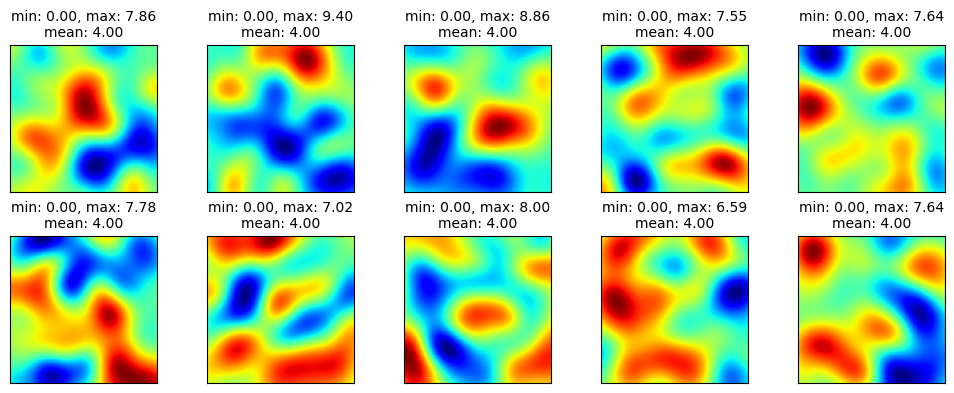

In [100]:
N_CELLS = 200
WSM_SIGMA = 12
WSM_SSIGMA = 0
WSM_MAGNITUDE = 4  # Mean magnitude of the response map, in paper I used 10 as the max magnitude, which has mean about 4
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

wsm = WeakSMCell(
    arena_map=arena_map,
    n_cells=N_CELLS,
    sigma=WSM_SIGMA,
    ssigma=WSM_SSIGMA,
    magnitude=WSM_MAGNITUDE,
)

# Visualize the response map
visualize_response_map(wsm.response_map, im_width=2)


# Initialize the RAE

In [101]:
N_HIDDEN = 1024

# NOTE: for linear layer, there are two additional parameters:
# `sparsity_mask`: a binary mask with the same shape as the weight matrix, where 1 means the weight is learnable and 0 means it is not
# `positivity_mask`: a binary mask with the same shape as the weight matrix, where 1 means the weight is excitatory and -1 means it is inhibitory
# Both of them are not used in this project, and the positivity mask might be deprecated, be cautious when using it

# Initialize the RAE
input_layer = LinearLayer(
    input_dim=N_CELLS,
    output_dim=N_HIDDEN
)
output_layer = LinearLayer(
    input_dim=N_HIDDEN,
    output_dim=N_CELLS
)
leaky_layer = LeakyLinearLayer(
    linear_layer=LinearLayer(input_dim=N_HIDDEN, output_dim=N_HIDDEN),
    activation=torch.nn.ReLU(),
    alpha=0.1,  # If alpha is learnable, this will be the initial value
    learn_alpha=False,  # If True, the alpha (forgetting rate) for each hidden unit is learned
    preact_noise=0,  # The noise added before the activation at each timestep
    postact_noise=0,  # The noise added after the activation at each timestep
)
rae = RNN(
    readout_layer=output_layer,
    recurrent_layers=[RecurrentLayer(
        leaky_layer=leaky_layer,
        projection_layer=input_layer,
    )]
)
rae = rae.to(DEVICE)

# Training

In [102]:
MASK_RATE = 0.50  # 50% of the inputs are masked

def masking(x, mask_rate):
    B, T, _ = x.shape
    # Each time_step and batch_size are masked independently
    mask = torch.bernoulli(torch.ones(B, T) * (1 - mask_rate)).to(x.device)
    return x * mask.unsqueeze(2)

res = wsm.get_response(traj_coord[:, :1000])
res = masking(torch.as_tensor(res), MASK_RATE)
# Sanity check: count the ratio of zero in res
print("The ratio of zeros after masking is", f"{torch.sum(res == 0) / res.numel():.2%}")

The ratio of zeros after masking is 49.75%


In [ ]:
# Begin training
LEARNING_RATE = 0.005
N_EPOCHS = 10
STEP_SIZE = 20  # 20 steps * 50ms = 1 second
LAMBDA_MSE = 1
LAMBDA_FR = 20

# Rebatch traj_coord from (128, Ts, 2) to (512, Ts//4, 2), feel free to change the batch size
traj_coord = traj_coord.reshape(128, 4, -1, 2)
traj_coord = traj_coord.reshape(512, -1, 2)

optimizer = torch.optim.Adam(rae.parameters(), lr=LEARNING_RATE)

def fr_loss(states):
    mean_fr = torch.mean(states, dim=(0, 1)) # Average over time and batch
    return torch.pow(mean_fr, 2).mean()

for epoch in range(N_EPOCHS):
    print(f'Training epoch {epoch}')
    n_steps = traj_coord.shape[1] // STEP_SIZE
    for step in range(n_steps):
        optimizer.zero_grad()

        # Get the response of the current step
        tc = traj_coord[:, step * STEP_SIZE:(step + 1) * STEP_SIZE]
        gt_res = torch.as_tensor(wsm.get_response(tc), dtype=torch.float32).to(DEVICE)
        # Masked_res and gt_res are offset by 1
        masked_res = masking(gt_res[:, :-1], MASK_RATE)
        gt_res = gt_res[:, 1:]

        # Forward pass
        pred, states = rae(masked_res)
        l_mse = F.mse_loss(pred, gt_res) * LAMBDA_MSE
        # By default RNN uses multi-layer format, so the states is a list of states, 
        # since we only have one layer, use states[0] here.
        l_fr = fr_loss(states[0]) * LAMBDA_FR 
        loss = l_mse + l_fr

        # Backward pass
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0 and step != 0:  # Print every 10 steps
            print(f'Step {step}/{n_steps}, MSE Loss: {l_mse.item():.4f}, FR Loss: {l_fr.item():.4f}')
            torch.save({'rae': rae.state_dict()}, os.path.join(os.getcwd(), 'ckpts', f'latest.pth'))

        # Save the model
        torch.save({'rae': rae.state_dict()}, os.path.join(os.getcwd(), 'ckpts', f'rae_{epoch}.pth'))


# Testing

In [116]:
load_version = 'latest'
rae_state_dict = torch.load(os.path.join(os.getcwd(), 'ckpts', f'{load_version}.pth'))['rae']
rae.load_state_dict(rae_state_dict)
rae = rae.to(DEVICE)

In [117]:
rm_agg = RatemapAggregator(arena_map=arena_map, device=DEVICE)

n_test = min(500, traj_coord.shape[1] // STEP_SIZE)
with torch.no_grad():
    for step in range(n_test):
        # Get the response of the current step
        tc = traj_coord[:, step * STEP_SIZE:(step + 1) * STEP_SIZE]
        gt_res = torch.as_tensor(wsm.get_response(tc), dtype=torch.float32).to(DEVICE)
        # Masked_res and gt_res are offset by 1
        masked_res = masking(gt_res[:, :-1], MASK_RATE)
        gt_res = gt_res[:, 1:]

        # Forward pass
        pred, states = rae(masked_res)

        # Update the rate map
        rm_agg.update(coords=tc[:, 1:], states=states[0])

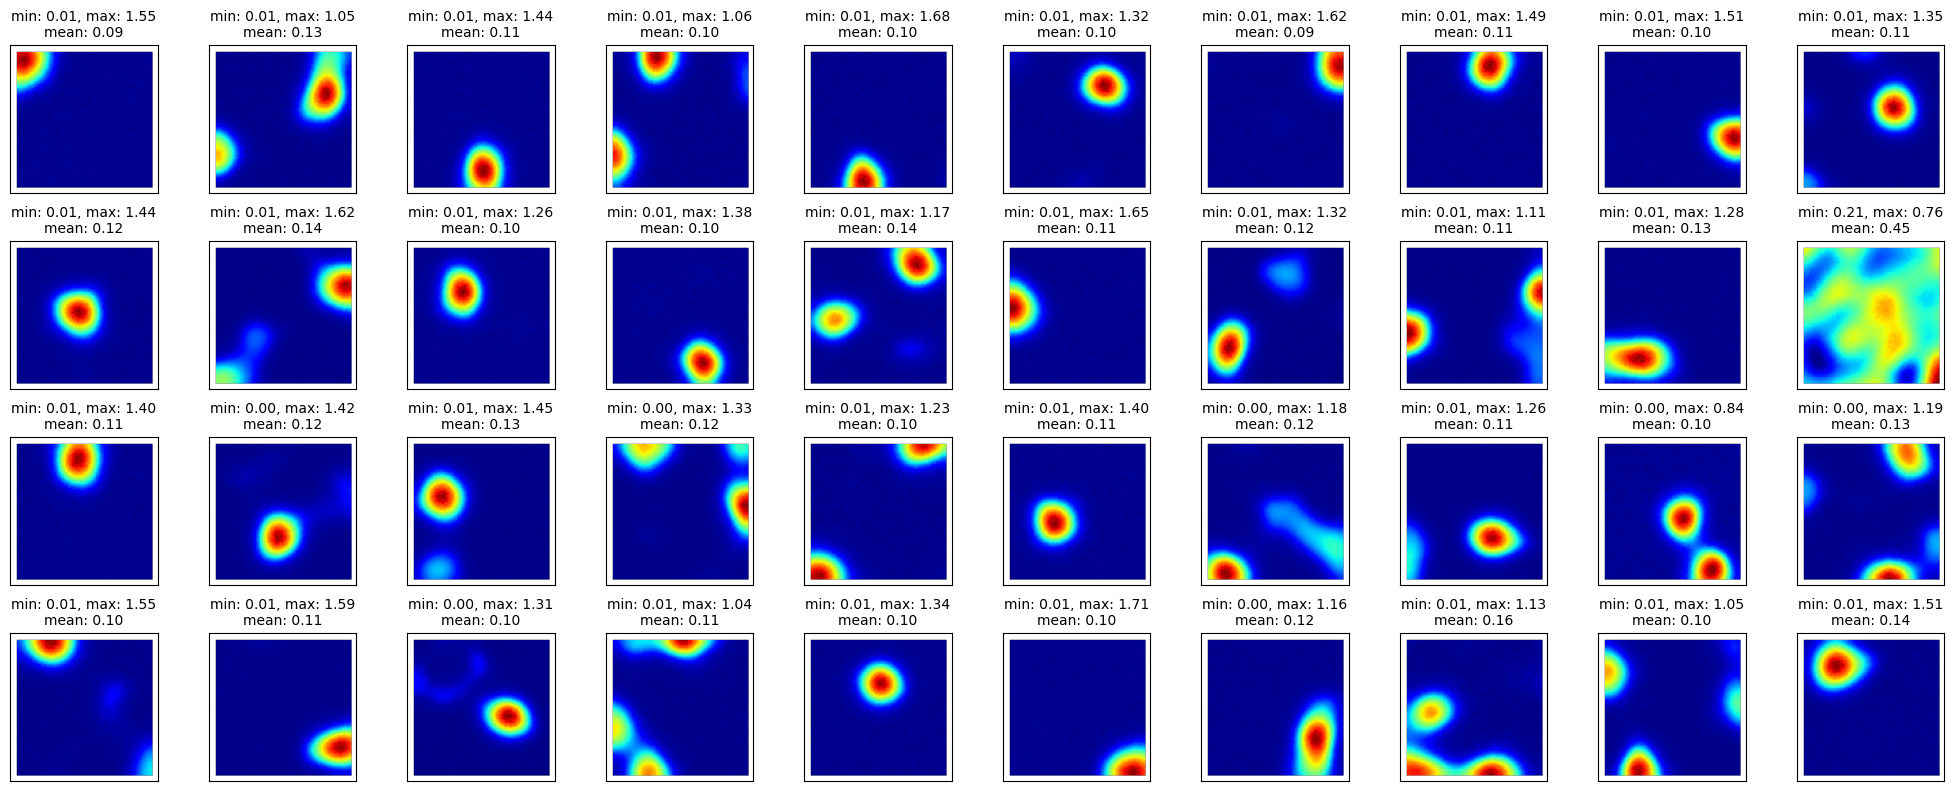

In [118]:
rm = rm_agg.get_ratemap().cpu().numpy()
rm = rm[np.nanmax(rm, axis=(1, 2)) > 0.2]
N_COLS = 10
N_ROWS = min(5, rm.shape[0] // N_COLS)
visualize_response_map(rm, random_cell=True, im_width=2, n_cols=N_COLS, n_rows=N_ROWS)